<a href="https://colab.research.google.com/github/karthikstar/SC1015-Project/blob/main/Multi_Class_COVID_Classification_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**SC1015 Mini-Project**
Done By Elangovan Karthikeyan, Lam Wei Lin Zoey, Lee Pei Yee From BCF1

## Pneumonia Detection Via Chest X-Ray Images
>The COVID-19 pandemic has disrupted the way of life for billions of people around the world. COVID-19 pneumonia is a serious illness that can be deadly. Given the situation above, we felt it was apt to work on pneumonia detection which could help doctors to more accurately detect pneumonia from chest x-ray images. 

>Thus, we will be training a model that is able to detect pneumonia in Chest X-Ray images.

>Firstly, we seek to build a Convolutional Neural Network (CNN) model, following which we will build a more advanced model by performing transfer learning using a famous Imagenet Model known as InceptionV3. 

>Along the way we will also use the new tf.data along with Pandas to handle the input pipelines for training and testing.

<div style="width:40%;text-align: center;padding-left='40px'"> 
    <br>
    <center><img src="https://upload.wikimedia.org/wikipedia/commons/7/72/Projectional_rendering_of_CT_scan_of_thorax_%28thumbnail%29.gif" alt="chest x ray img"></center>
</div>


#Data Preparation and Cleaning

Importing Basic Libraries

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
#Testing for GPU 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Importing Dataset using Kaggle API (kaggle.json file required)

In [3]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/muratkokludataset/acoustic-extinguisher-fire-dataset                  Acoustic Extinguisher Fire Dataset               621KB  2022-04-02 22:59:36            270        318  0.9375           
datasets/piterfm/2022-ukraine-russian-war                                      2022 Ukraine Russia War                            2KB  2022-04-23 19:46:16          10864        596  1.0              
datasets/muhmores/spotify-top-100-songs-of-20152019                            Spotify Top 100 Songs of 2010-2019               139KB  2022-04-09 06:35:36           1

In [4]:
! kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 769M/778M [00:13<00:00, 69.7MB/s]
100% 778M/778M [00:13<00:00, 61.6MB/s]


In [5]:
#Unzipping the data

!unzip -qq covid19-radiography-database.zip
!rm covid19-radiography-database.zip

In [6]:
!ls

COVID-19_Radiography_Dataset  kaggle.json  sample_data


In [7]:
!wget -qq https://www.dropbox.com/s/vj61417lofjebju/utils.zip
!unzip -qq utils.zip
!rm utils.zip

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt


import os, json
from glob import glob
import numpy as np


In [9]:
print(tf.__version__)
print(tf.keras.__version__)


2.8.0
2.8.0


Inspecting the Dataset

In [10]:
!ls COVID-19_Radiography_Dataset/

 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		     'Viral Pneumonia'
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 Normal


In [11]:
#checking out file directory for Covid Images
!ls COVID-19_Radiography_Dataset/COVID/images/

COVID-1000.png	COVID-1653.png	COVID-2304.png	COVID-2957.png	COVID-3608.png
COVID-1001.png	COVID-1654.png	COVID-2305.png	COVID-2958.png	COVID-3609.png
COVID-1002.png	COVID-1655.png	COVID-2306.png	COVID-2959.png	COVID-360.png
COVID-1003.png	COVID-1656.png	COVID-2307.png	COVID-295.png	COVID-3610.png
COVID-1004.png	COVID-1657.png	COVID-2308.png	COVID-2960.png	COVID-3611.png
COVID-1005.png	COVID-1658.png	COVID-2309.png	COVID-2961.png	COVID-3612.png
COVID-1006.png	COVID-1659.png	COVID-230.png	COVID-2962.png	COVID-3613.png
COVID-1007.png	COVID-165.png	COVID-2310.png	COVID-2963.png	COVID-3614.png
COVID-1008.png	COVID-1660.png	COVID-2311.png	COVID-2964.png	COVID-3615.png
COVID-1009.png	COVID-1661.png	COVID-2312.png	COVID-2965.png	COVID-3616.png
COVID-100.png	COVID-1662.png	COVID-2313.png	COVID-2966.png	COVID-361.png
COVID-1010.png	COVID-1663.png	COVID-2314.png	COVID-2967.png	COVID-362.png
COVID-1011.png	COVID-1664.png	COVID-2315.png	COVID-2968.png	COVID-363.png
COVID-1012.png	COVID-1665.png	COV

Generating Lists of Filenames for Each of the 3 Classes - Normal, Viral Pneumonia and COVID

In [12]:
import glob
import pandas as pd

In [13]:
files_normal = glob.glob('./COVID-19_Radiography_Dataset/Normal/images/*.png')
files_viral = glob.glob('./COVID-19_Radiography_Dataset/Viral Pneumonia/images/*.png')
files_COVID = glob.glob('./COVID-19_Radiography_Dataset/COVID/images/*.png')
#files_Lung = glob.glob('./COVID-19_Radiography_Dataset/Lung Opacity/images/*.png')

In [14]:
print(len(files_normal))
print(len(files_viral))
print(len(files_COVID))
#print(len(files_Lung))

10192
1345
3616


Cleaning Data by Checking for Full White/Black Images in Files To Be Eliminated from dataset

In [15]:
from PIL import Image

def checkFullWhiteOrBlack(folder):
  count = 0
  for i in range(len(folder)):
    img = Image.open(folder[i])
    clrs = img.getcolors() 
    if(len(clrs) == 1):
      count += 1
  return count

print("No Of Full White/Black Images in Files - Normal" , checkFullWhiteOrBlack(files_normal))
print("No Of Full White/Black Images in Files - Viral" , checkFullWhiteOrBlack(files_viral))
print("No Of Full White/Black Images in Files - COVID" , checkFullWhiteOrBlack(files_COVID))


No Of Full White/Black Images in Files - Normal 0
No Of Full White/Black Images in Files - Viral 0
No Of Full White/Black Images in Files - COVID 0


It can be observed that there are no full white/black images in all the files, hence no further cleaning is required.

Checking amount of image data for each of the 3 classes

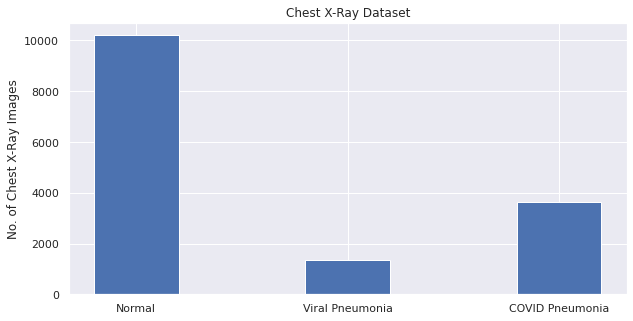

In [16]:
import numpy as np
import matplotlib.pyplot as plt
 
  
# creating the dataset
data = {'Normal':len(files_normal), 'Viral Pneumonia':len(files_viral), 'COVID Pneumonia':len(files_COVID)}
pneumType = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(pneumType, values,
        width = 0.4)
 
plt.ylabel("No. of Chest X-Ray Images")
plt.title("Chest X-Ray Dataset")
plt.show()


As we can see above, there is a severe imbalance in the amount of chest x-ray image data for Normal, Viral Pneumonia and COVID Pneumonia. Thus, we will perform undersampling to balance out the number of chest x-ray images for each category.

In [17]:
import numpy as np
np.random.seed(42)
files_normal = np.random.choice(files_normal,1345,replace=False)
files_viral = np.random.choice(files_viral,1345,replace=False)
files_COVID = np.random.choice(files_COVID,1345,replace=False)


In [18]:
print(len(files_normal))
print(len(files_viral))
print(len(files_COVID))

1345
1345
1345


In [19]:
from sklearn.model_selection import train_test_split

normal_train, normal_test = train_test_split(files_normal, test_size=0.2, random_state=42, shuffle = True)
normal_valid, normal_test = train_test_split(normal_test, test_size=0.5, random_state=42, shuffle = True)
viral_train, viral_test = train_test_split(files_viral, test_size=0.2, random_state=42, shuffle = True)
viral_valid, viral_test = train_test_split(viral_test, test_size=0.5, random_state=42, shuffle = True)
COVID_train, COVID_test = train_test_split(files_COVID, test_size=0.2, random_state=42, shuffle = True)
COVID_valid, COVID_test = train_test_split(COVID_test, test_size=0.5, random_state=42, shuffle = True)

In [20]:
print("normal-train: ",len(normal_train))
print("normal-valid: ",len(normal_valid))
print("normal-test: ",len(normal_test))
print("Total Normal: ", len(normal_train) + len(normal_test)+len(normal_valid))
print()

print("viral-train: ",len(viral_train))
print("viral-valid: ",len(viral_valid))
print("viral-test: ",len(viral_test))
print("Total Viral: ", len(viral_train) + len(viral_test)+len(viral_valid))
print()

print("COVID-train: ", len(COVID_train))
print("COVID-valid: ", len(COVID_valid))
print("COVID-test: ", len(COVID_test))
print("Total COVID: ", len(COVID_train) + len(COVID_test)+ len(COVID_valid))
print()

print("Total Train dataset: ", len(normal_train) + len(viral_train)+len(COVID_train))
print("Total Valid dataset: ", len(normal_valid) + len(viral_valid)+len(COVID_valid))
print("Total Test dataset: ", len(normal_test) + len(viral_test)+len(COVID_test))


normal-train:  1076
normal-valid:  134
normal-test:  135
Total Normal:  1345

viral-train:  1076
viral-valid:  134
viral-test:  135
Total Viral:  1345

COVID-train:  1076
COVID-valid:  134
COVID-test:  135
Total COVID:  1345

Total Train dataset:  3228
Total Valid dataset:  402
Total Test dataset:  405


In [21]:
#converting to Dataframe
df_train_normal = pd.DataFrame(normal_train, columns=["filename"])
df_train_viral = pd.DataFrame(viral_train, columns=["filename"])
df_train_COVID = pd.DataFrame(COVID_train, columns=["filename"])

df_valid_normal = pd.DataFrame(normal_valid, columns=["filename"])
df_valid_viral = pd.DataFrame(viral_valid, columns=["filename"])
df_valid_COVID = pd.DataFrame(COVID_valid, columns=["filename"])

df_test_normal = pd.DataFrame(normal_test, columns=["filename"])
df_test_viral = pd.DataFrame(viral_test, columns=["filename"])
df_test_COVID = pd.DataFrame(COVID_test, columns=["filename"])

In [22]:
df_train_normal.head()

,filename
0,./COVID-19_Radiography_Dataset/Normal/images/N...
1,./COVID-19_Radiography_Dataset/Normal/images/N...
2,./COVID-19_Radiography_Dataset/Normal/images/N...
3,./COVID-19_Radiography_Dataset/Normal/images/N...
4,./COVID-19_Radiography_Dataset/Normal/images/N...


## Encoding of Classes for the data
We assign 0 for normal, 1 for viral pneumonia and 2 for COVID

In [23]:
#Assigned class for normal - 0, viral - 1 , COVID - 2 - check if we wanna assign 0 to viral as well!

df_train_normal['class'] = pd.Series([0 for x in range(len(df_train_normal.index))], index=df_train_normal.index)
df_train_viral['class'] = pd.Series([1 for x in range(len(df_train_viral.index))], index=df_train_viral.index)
df_train_COVID['class'] = pd.Series([2 for x in range(len(df_train_COVID.index))], index=df_train_COVID.index)

df_test_normal['class'] = pd.Series([0 for x in range(len(df_test_normal.index))], index=df_test_normal.index)
df_test_viral['class'] = pd.Series([1 for x in range(len(df_test_viral.index))], index=df_test_viral.index)
df_test_COVID['class'] = pd.Series([2 for x in range(len(df_test_COVID.index))], index=df_test_COVID.index)

df_valid_normal['class'] = pd.Series([0 for x in range(len(df_valid_normal.index))], index=df_valid_normal.index)
df_valid_viral['class'] = pd.Series([1 for x in range(len(df_valid_viral.index))], index=df_valid_viral.index)
df_valid_COVID['class'] = pd.Series([2 for x in range(len(df_valid_COVID.index))], index=df_valid_COVID.index)
df_train_normal.head()

,filename,class
0,./COVID-19_Radiography_Dataset/Normal/images/N...,0
1,./COVID-19_Radiography_Dataset/Normal/images/N...,0
2,./COVID-19_Radiography_Dataset/Normal/images/N...,0
3,./COVID-19_Radiography_Dataset/Normal/images/N...,0
4,./COVID-19_Radiography_Dataset/Normal/images/N...,0


In [24]:
print(df_train_normal.head())
print(df_train_viral.head())
print(df_train_COVID.head())
print(df_valid_normal.head())
print(df_valid_viral.head())
print(df_valid_COVID.head())
print(df_test_normal.head())
print(df_test_viral.head())
print(df_test_COVID.head())

                                            filename  class
0  ./COVID-19_Radiography_Dataset/Normal/images/N...      0
1  ./COVID-19_Radiography_Dataset/Normal/images/N...      0
2  ./COVID-19_Radiography_Dataset/Normal/images/N...      0
3  ./COVID-19_Radiography_Dataset/Normal/images/N...      0
4  ./COVID-19_Radiography_Dataset/Normal/images/N...      0
                                            filename  class
0  ./COVID-19_Radiography_Dataset/Viral Pneumonia...      1
1  ./COVID-19_Radiography_Dataset/Viral Pneumonia...      1
2  ./COVID-19_Radiography_Dataset/Viral Pneumonia...      1
3  ./COVID-19_Radiography_Dataset/Viral Pneumonia...      1
4  ./COVID-19_Radiography_Dataset/Viral Pneumonia...      1
                                            filename  class
0  ./COVID-19_Radiography_Dataset/COVID/images/CO...      2
1  ./COVID-19_Radiography_Dataset/COVID/images/CO...      2
2  ./COVID-19_Radiography_Dataset/COVID/images/CO...      2
3  ./COVID-19_Radiography_Dataset/COVID/

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

#from sutils import *
import os, json
from glob import glob
import numpy as np
import tensorflow
import keras

from keras import optimizers

from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16

from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model,load_model,Sequential

from keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Dropout, Flatten
from keras import backend as K

from keras.callbacks import ModelCheckpoint, Callback

In [26]:
# Set up some Hyperparameters

batch_size = 32
epochs = 10

lr = 0.001

In [27]:
df_new_train = pd.concat([df_train_normal, df_train_viral, df_train_COVID])
df_new_val = pd.concat([df_valid_normal, df_valid_viral, df_valid_COVID])
df_new_test = pd.concat([df_test_normal, df_test_viral, df_test_COVID])


# Shuffle
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)
df_test = df_new_test.sample(frac=1).reset_index(drop=True)

In [28]:
df.head()

,filename,class
0,./COVID-19_Radiography_Dataset/Normal/images/N...,0
1,./COVID-19_Radiography_Dataset/Normal/images/N...,0
2,./COVID-19_Radiography_Dataset/Normal/images/N...,0
3,./COVID-19_Radiography_Dataset/COVID/images/CO...,2
4,./COVID-19_Radiography_Dataset/COVID/images/CO...,2


In [29]:
df_val.head()

,filename,class
0,./COVID-19_Radiography_Dataset/Normal/images/N...,0
1,./COVID-19_Radiography_Dataset/COVID/images/CO...,2
2,./COVID-19_Radiography_Dataset/Viral Pneumonia...,1
3,./COVID-19_Radiography_Dataset/Normal/images/N...,0
4,./COVID-19_Radiography_Dataset/Viral Pneumonia...,1


In [30]:
df_test.head()

,filename,class
0,./COVID-19_Radiography_Dataset/Normal/images/N...,0
1,./COVID-19_Radiography_Dataset/COVID/images/CO...,2
2,./COVID-19_Radiography_Dataset/COVID/images/CO...,2
3,./COVID-19_Radiography_Dataset/Viral Pneumonia...,1
4,./COVID-19_Radiography_Dataset/Normal/images/N...,0


In [31]:
print(df.shape)
print(df_val.shape)
print(df_test.shape)

df['class'].unique()

#3228 train data, 402 validation data, 405 test data.

(3228, 2)
(402, 2)
(405, 2)


array([0, 2, 1])

In [32]:
print('Train data:')
print(df['class'].value_counts().sort_index())

print('Val data:')
print(df_val['class'].value_counts().sort_index())
print('Test data:')
print(df_test['class'].value_counts().sort_index())

Train data:
0    1076
1    1076
2    1076
Name: class, dtype: int64
Val data:
0    134
1    134
2    134
Name: class, dtype: int64
Test data:
0    135
1    135
2    135
Name: class, dtype: int64


# Exploratory Data Analysis (EDA)

Visualising distribution of the 3 classes (Normal, Viral and COVID) in the train dataset

0    1076
1    1076
2    1076
Name: class, dtype: int64


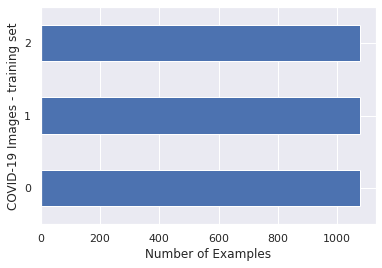

In [33]:
print(df['class'].value_counts().sort_index())

ax = df['class'].value_counts().sort_index().plot.barh()
ax.set_xlabel("Number of Examples", fontsize=12)
ax.set_ylabel("COVID-19 Images - training set", fontsize=12)
plt.show()

In [34]:
train_normal = df[df['class'] == 0]['filename'].tolist()
train_viral = df[df['class'] == 1]['filename'].tolist()
train_covid = df[df['class'] == 2]['filename'].tolist()


# Raw Comparison
First, we can start by simply looking at a few randomly sampled images.


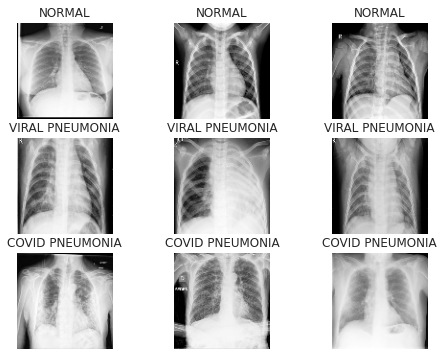

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
%matplotlib inline

# randomly select 3 of each
select_norm = np.random.choice(train_normal, 3, replace = False)
select_viral = np.random.choice(train_viral, 3, replace = False)
select_covid = np.random.choice(train_covid, 3, replace = False)

# plotting 3 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(9):
    if i < 3:
        fp = select_norm[i]
        label = 'NORMAL'
    elif i < 6:
        fp = select_viral[i -3]
        label = 'VIRAL PNEUMONIA'
    else:
        fp = select_covid[i - 6]
        label = 'COVID PNEUMONIA'
    ax = fig.add_subplot(3, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()




#Images as Matrix
For the next few steps, we will work directly with the pixel values of each image so we can do operations on them. We can accomplish this by converting our images into a Numpy array.


In [36]:
def img2np(list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
normal_images = img2np(train_normal)
viral_images = img2np(train_viral)
covid_images = img2np(train_covid)

#Average Image
Now let’s see what the average image looks like for each class. To compute the average image, we can take the average value of each pixel across all observations.


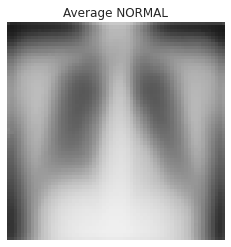

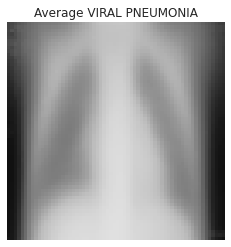

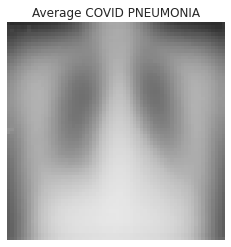

In [37]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(normal_images, 'NORMAL')
viral_mean = find_mean_img(viral_images, 'VIRAL PNEUMONIA')
covid_mean = find_mean_img(covid_images, 'COVID PNEUMONIA')


#Contrast Between Average Images
Using the average images, we can also compute the difference.


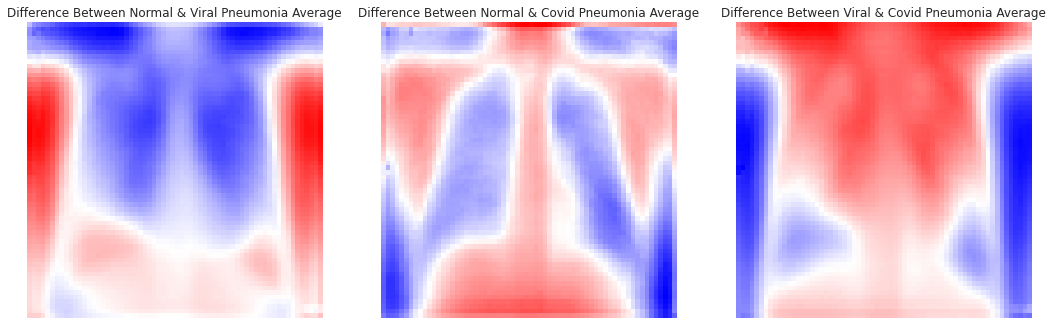

In [38]:
fig = plt.figure(figsize = (18,6))
for i in range(3):
    if i == 0:
        contrast_mean = norm_mean - viral_mean
        label = 'Difference Between Normal & Viral Pneumonia Average'
    elif i == 1:
        contrast_mean = norm_mean - covid_mean
        label = 'Difference Between Normal & Covid Pneumonia Average'
    else:
        contrast_mean = viral_mean - covid_mean
        label = 'Difference Between Viral & Covid Pneumonia Average'

    ax = fig.add_subplot(1, 3, i+1)
    
    plt.imshow(contrast_mean, cmap='bwr',)
    plt.title(label)
    plt.axis('off')
plt.show()

#Eigenimages
Lastly, we can use a dimension reduction technique such as the principal component analysis (PCA) to visualize the components that describe each class the best. The eigenimages, which is essentially the eigenvectors (components) of PCA of our image matrix, can be reshaped into a matrix and be plotted. Here we will visualize the principal components that describe 70% of variability for each class.


In [39]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()

Principal components that describe 70% of variability for NORMAL class.
Number of PC:  9


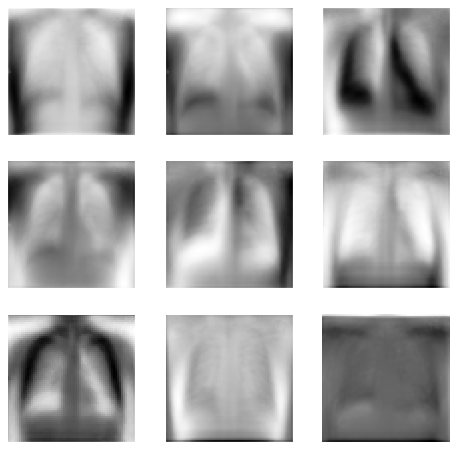

In [40]:
print("Principal components that describe 70% of variability for NORMAL class.")
plot_pca(eigenimages(normal_images, 'NORMAL'))

Principal components that describe 70% of variability for VIRAL class.
Number of PC:  12


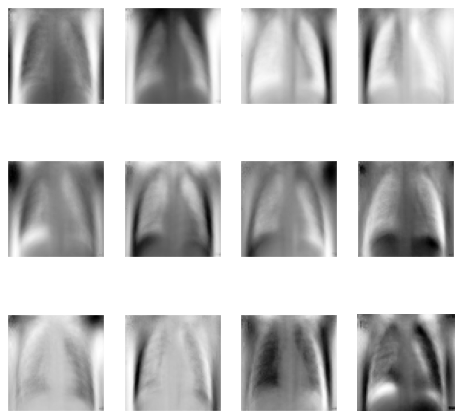

In [41]:
print("Principal components that describe 70% of variability for VIRAL class.")
plot_pca(eigenimages(viral_images, 'VIRAL'))

Principal components that describe 70% of variability for COVID class.
Number of PC:  8


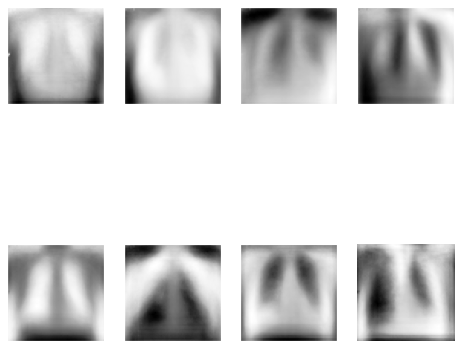

In [42]:
print("Principal components that describe 70% of variability for COVID class.")
plot_pca(eigenimages(covid_images, 'COVID'))

# Image Value Distribution

In [43]:
import seaborn as sns
import numpy as np

mean = {"normal_mean":[],"viral_mean":[],"covid_mean":[]}
min = {"normal_min":[],"viral_min":[],"covid_min":[]}
max = {"normal_max":[],"viral_max":[],"covid_max":[]}
std = {"normal_std":[],"viral_std":[],"covid_std":[]}

for i in range(len(normal_images)):
  mean["normal_mean"].append(normal_images[i].mean())
  min["normal_min"].append(normal_images[i].min())
  max["normal_max"].append(normal_images[i].max())
  std["normal_std"].append(np.std(normal_images[i]))

for i in range(len(viral_images)):
  mean["viral_mean"].append(viral_images[i].mean())
  min["viral_min"].append(viral_images[i].min())
  max["viral_max"].append(viral_images[i].max())
  std["viral_std"].append(np.std(viral_images[i]))

for i in range(len(covid_images)):
  mean["covid_mean"].append(covid_images[i].mean())
  min["covid_min"].append(covid_images[i].min())
  max["covid_max"].append(covid_images[i].max())
  std["covid_std"].append(np.std(covid_images[i]))


In [44]:
data1 = {
    "normal" : {"mean":[],"min":[],"max":[], "std":[]},
    "viral" : {"mean":[],"min":[],"max":[], "std":[]},
    "covid" : {"mean":[],"min":[],"max":[],"std":[]} 
}


for i in range(len(normal_images)):
  data1["normal"]["mean"].append(normal_images[i].mean())
  data1["normal"]["min"].append(normal_images[i].min())
  data1["normal"]["max"].append(normal_images[i].max())
  data1["normal"]["std"].append(np.std(normal_images[i]))

for i in range(len(viral_images)):
  data1["viral"]["mean"].append(viral_images[i].mean())
  data1["viral"]["min"].append(viral_images[i].min())
  data1["viral"]["max"].append(viral_images[i].max())
  data1["viral"]["std"].append(np.std(viral_images[i]))

for i in range(len(covid_images)):
  data1["covid"]["mean"].append(covid_images[i].mean())
  data1["covid"]["min"].append(covid_images[i].min())
  data1["covid"]["max"].append(covid_images[i].max())
  data1["covid"]["std"].append(np.std(covid_images[i]))

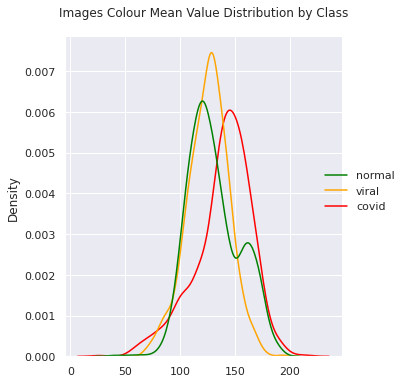

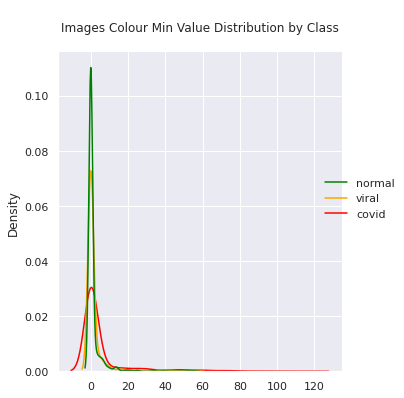

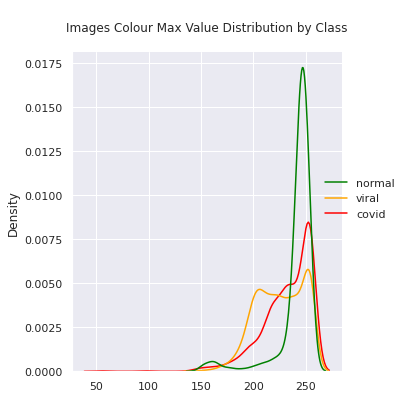

In [45]:
palette = ["green","orange","red"]
ax1 = sns.displot(data = [data1["normal"]["mean"], data1["viral"]["mean"], data1["covid"]["mean"]],kind = 'kde', palette = palette)

plt.title('Images Colour Mean Value Distribution by Class\n', fontsize = 12, );

ax2 = sns.displot(data = [data1["normal"]["min"], data1["viral"]["min"], data1["covid"]["min"]],kind = 'kde',palette = palette)
plt.title('\nImages Colour Min Value Distribution by Class\n', fontsize = 12, );

ax3 = sns.displot(data = [data1["normal"]["max"], data1["viral"]["max"], data1["covid"]["max"]],kind = 'kde',palette = palette)
plt.title('\nImages Colour Max Value Distribution by Class\n', fontsize = 12);

new_labels = ['normal','viral','covid']
for i in [ax1,ax2,ax3]:
  for t,l in zip(i._legend.texts, new_labels):
    t.set_text(l)


(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.]),
 <a list of 11 Text major ticklabel objects>)

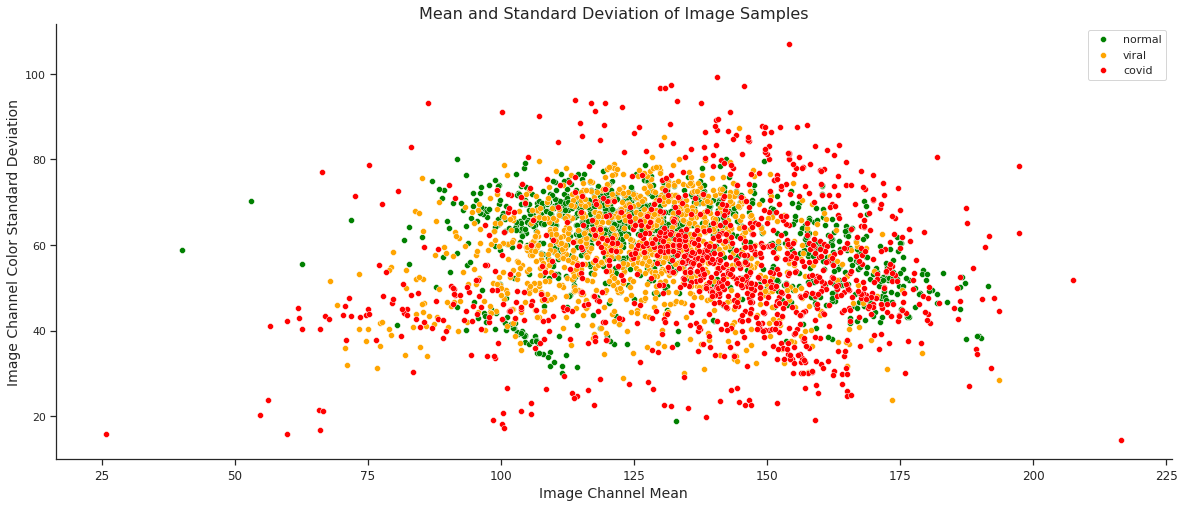

In [46]:
plt.figure(figsize = (20, 8))
colors = {"normal":"green","viral":"orange","covid":"red"}
sns.set(style = "ticks", font_scale = 1)
for key in data1:
  ax = sns.scatterplot(data = data1[key], x = "mean", y = "std", label = key, color = colors[key])

plt.xlabel("Image Channel Mean", fontsize = 14)
plt.ylabel("Image Channel Color Standard Deviation",  fontsize = 14)
plt.title('Mean and Standard Deviation of Image Samples',  fontsize = 16)

sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)


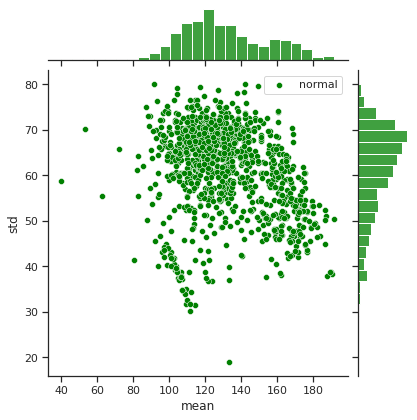

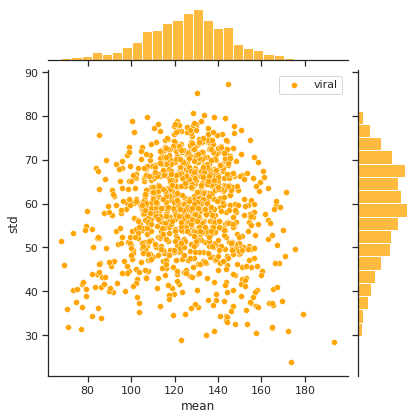

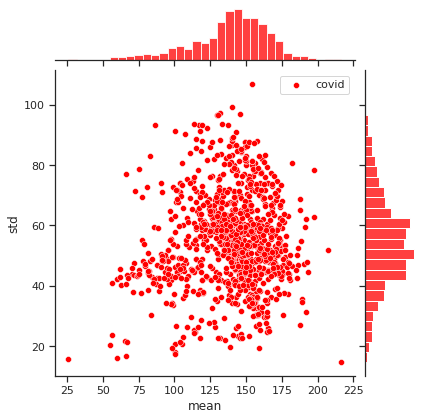

In [47]:
sns.jointplot(data = data1["normal"], x = "mean", y = "std", label = "normal",color="green")
sns.jointplot(data = data1["viral"], x = "mean", y = "std", label = "viral",color="orange")
sns.jointplot(data = data1["covid"], x = "mean", y = "std", label = "covid",color="red")

#Preparing Machine Learning Pipeline to load images

In [48]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
test_filenames_list = df_test["filename"].tolist()
test_labels_list = df_test["class"].astype('int32').tolist()

#number of classes
num_classes = 3

In [49]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 299,299

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [50]:
# A vector of filenames - from a list
filenames = tf.constant(train_filenames_list)

# Labels that match the training files - from a list
labels = tf.constant(train_labels_list)

# Same as above but for validation set
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

# Same as above but for test set
test_filenames = tf.constant(test_filenames_list)
test_labels = tf.constant(test_labels_list)


In [51]:
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(100)
train_dataset = train_dataset.batch(32)

In [52]:
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat(100)
valid_dataset = valid_dataset.batch(32)

In [53]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.repeat(100)
test_dataset = test_dataset.batch(32)

In [54]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

##Building A Convolutional Neural Network (CNN) Model

In [55]:
from tensorflow.keras import layers, models

cnn_model = tf.keras.models.Sequential()
cnn_model.add(layers.BatchNormalization(input_shape=(299,299,3)))
cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.35))

cnn_model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units = 128, activation = 'relu'))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Dense(units = 3, activation = 'softmax'))

cnn_model.compile(optimizer = 'adam', 
          loss = 'categorical_crossentropy',
           metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 299, 299, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 297, 297, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 148, 148, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0

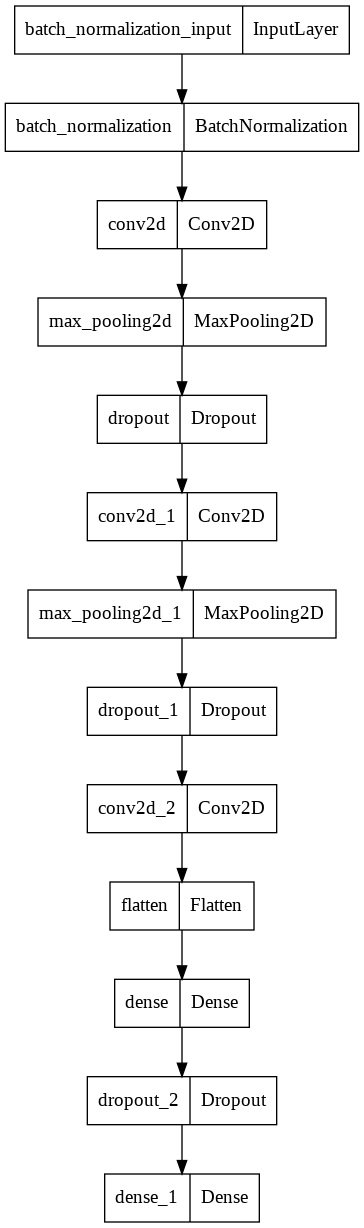

In [56]:
from keras.utils.vis_utils import plot_model

plot_model(cnn_model,to_file='cnn_plot.png')

In [57]:
#Checkpoints
!mkdir checkpoints
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
checkpoint1 = ModelCheckpoint('./checkpoints/best_weights_CNNModel.hdf5', verbose=1, save_best_only=True, mode='auto')

train_steps = 100
val_steps = 50
epochs = 10

history_cnn = cnn_model.fit(train_dataset, steps_per_epoch = train_steps,
                        epochs = epochs, 
                        validation_data = valid_dataset,
                        validation_steps = val_steps,
                        callbacks=[es,checkpoint1]
                        )

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.8718 - accuracy: 0.6812
Epoch 1: val_loss improved from inf to 0.97343, saving model to ./checkpoints/best_weights_CNNModel.hdf5
100/100 [==============================] - 52s 392ms/step - loss: 0.8718 - accuracy: 0.6812 - val_loss: 0.9734 - val_accuracy: 0.7081
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.5357 - accuracy: 0.7644
Epoch 2: val_loss improved from 0.97343 to 0.57920, saving model to ./checkpoints/best_weights_CNNModel.hdf5
100/100 [==============================] - 38s 383ms/step - loss: 0.5357 - accuracy: 0.7644 - val_loss: 0.5792 - val_accuracy: 0.7556
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.4948 - accuracy: 0.7828
Epoch 3: val_loss did not improve from 0.57920
100/100 [==============================] - 38s 380ms/step - loss: 0.4948 - accuracy: 0.7828 - val_loss: 0.6534 - val_accuracy: 0.7431
Epoch 4/10
100/100 [=============================

In [58]:
def plot_loss_acc(hist):

  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc = 'lower right')
  plt.show()

  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc = 'upper right')
  plt.show()


Plotting Model Accuracy and Loss for Train and Validation Data

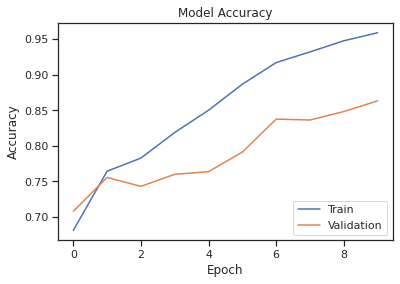

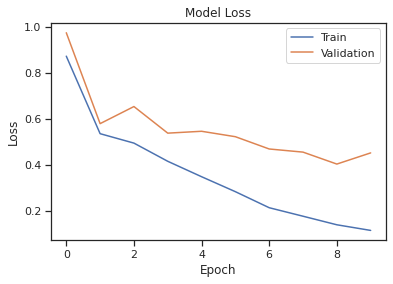

In [59]:
plot_loss_acc(history_cnn)

Evaluating CNN Model's Test Accuracy

In [60]:
metrics = cnn_model.evaluate(test_dataset,steps=50)
print("model accuracy:",metrics[1])

50/50 [==============================] - 7s 144ms/step - loss: 0.3920 - accuracy: 0.8475
model accuracy: 0.8475000262260437


As we see above, the test accuracy is about 88%, thus there is some room for improvement in terms of accuracy. We can also observe that at intiial epochs, validation accuracy seems to be higher than training accuracy. 

This means that the network is probably struggling to fit the training data hence we could possibly explore a bigger network, or a different architecture, or use more advanced optimization algorithms.

We can also observe signs of overfitting at later epochs, where we see that the train accuracy is rising while the validation accuracy is decreasing.

Thus, we now proceed to use Transfer Learning using pre-trained models, which are more sophisticated and large, to seek for a higher accuracy and eliminate some of the weaknesses as illustrated above.

# Building a more Complex model using Transfer Learning with pre-trained model - Inception V3
We are going to be using InceptionV3 as it has the combination of 2 parameters that we are looking out for, good accuracy and low parameters, to ensure that this model remains lightweight while being able to give a good accuracy, so that it will be feasible to deploy at healthcare instituitions 

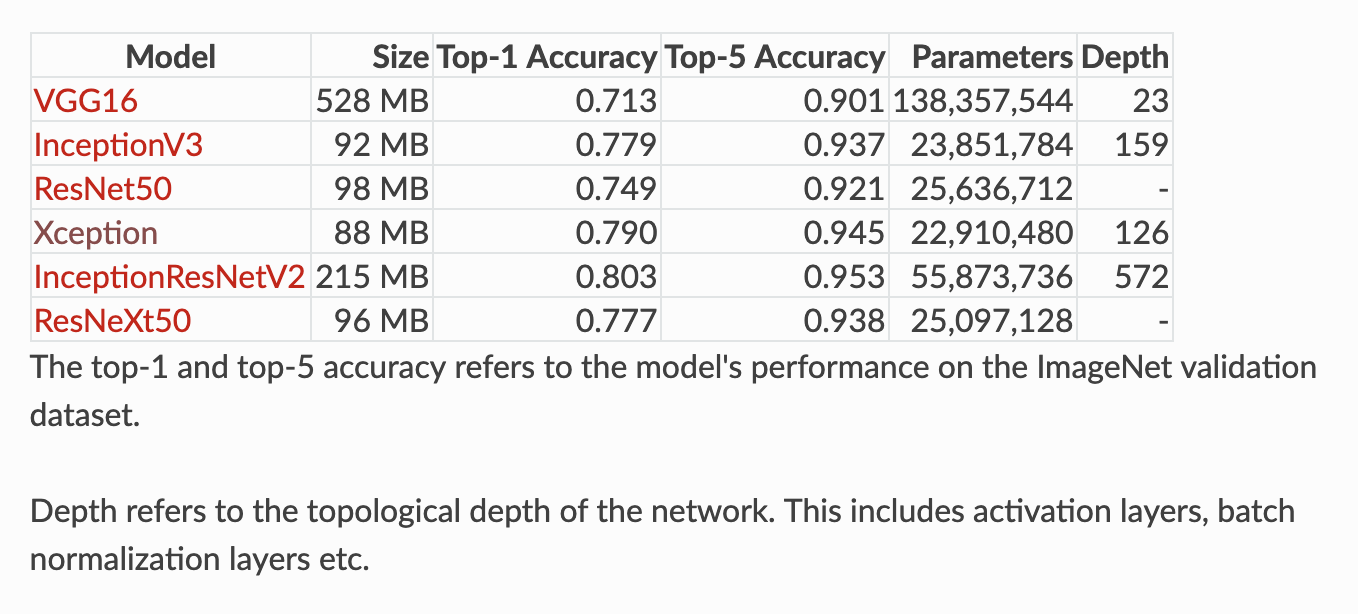

#Loading InceptionV3 Base Model

In [61]:
# InceptionV3 Model - trained on image net
base_model = InceptionV3(include_top=False, weights='imagenet')


87924736/87910968 [==============================] - 1s 0us/step


In [62]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_3 (Conv2D)              (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_1 (BatchNo  (None, None, None,   96         ['conv2d_3[0][0]']               
 rmalization)                   32)                                                    

## Create a simple head for the model that we can train

In [63]:
#add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# 3 Classes for Detection of Pneumonia
num_classes = 3
predictions = Dense(num_classes, activation='softmax')(x)

In [64]:
# Creating the model that we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [65]:
# Freeze the InceptionV3 layers except the BatchNorm
for layer in base_model.layers:
    if 'batch' in layer.name:
      print(layer.name)
      layer.trainable = True
    else:
      layer.trainable = False 

batch_normalization_1
batch_normalization_2
batch_normalization_3
batch_normalization_4
batch_normalization_5
batch_normalization_9
batch_normalization_7
batch_normalization_10
batch_normalization_6
batch_normalization_8
batch_normalization_11
batch_normalization_12
batch_normalization_16
batch_normalization_14
batch_normalization_17
batch_normalization_13
batch_normalization_15
batch_normalization_18
batch_normalization_19
batch_normalization_23
batch_normalization_21
batch_normalization_24
batch_normalization_20
batch_normalization_22
batch_normalization_25
batch_normalization_26
batch_normalization_28
batch_normalization_29
batch_normalization_27
batch_normalization_30
batch_normalization_35
batch_normalization_36
batch_normalization_32
batch_normalization_37
batch_normalization_33
batch_normalization_38
batch_normalization_31
batch_normalization_34
batch_normalization_39
batch_normalization_40
batch_normalization_45
batch_normalization_46
batch_normalization_42
batch_normalization_

In [66]:
for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_1
False
conv2d_3
False
batch_normalization_1
True
activation
False
conv2d_4
False
batch_normalization_2
True
activation_1
False
conv2d_5
False
batch_normalization_3
True
activation_2
False
max_pooling2d_2
False
conv2d_6
False
batch_normalization_4
True
activation_3
False
conv2d_7
False
batch_normalization_5
True
activation_4
False
max_pooling2d_3
False
conv2d_11
False
batch_normalization_9
True
activation_8
False
conv2d_9
False
conv2d_12
False
batch_normalization_7
True
batch_normalization_10
True
activation_6
False
activation_9
False
average_pooling2d
False
conv2d_8
False
conv2d_10
False
conv2d_13
False
conv2d_14
False
batch_normalization_6
True
batch_normalization_8
True
batch_normalization_11
True
batch_normalization_12
True
activation_5
False
activation_7
False
activation_10
False
activation_11
False
mixed0
False
conv2d_18
False
batch_normalization_16
True
activation_15
False
conv2d_16
False
conv2d_19
False
batch_normalization_14
True
batch_normalization_17
True
activation_13

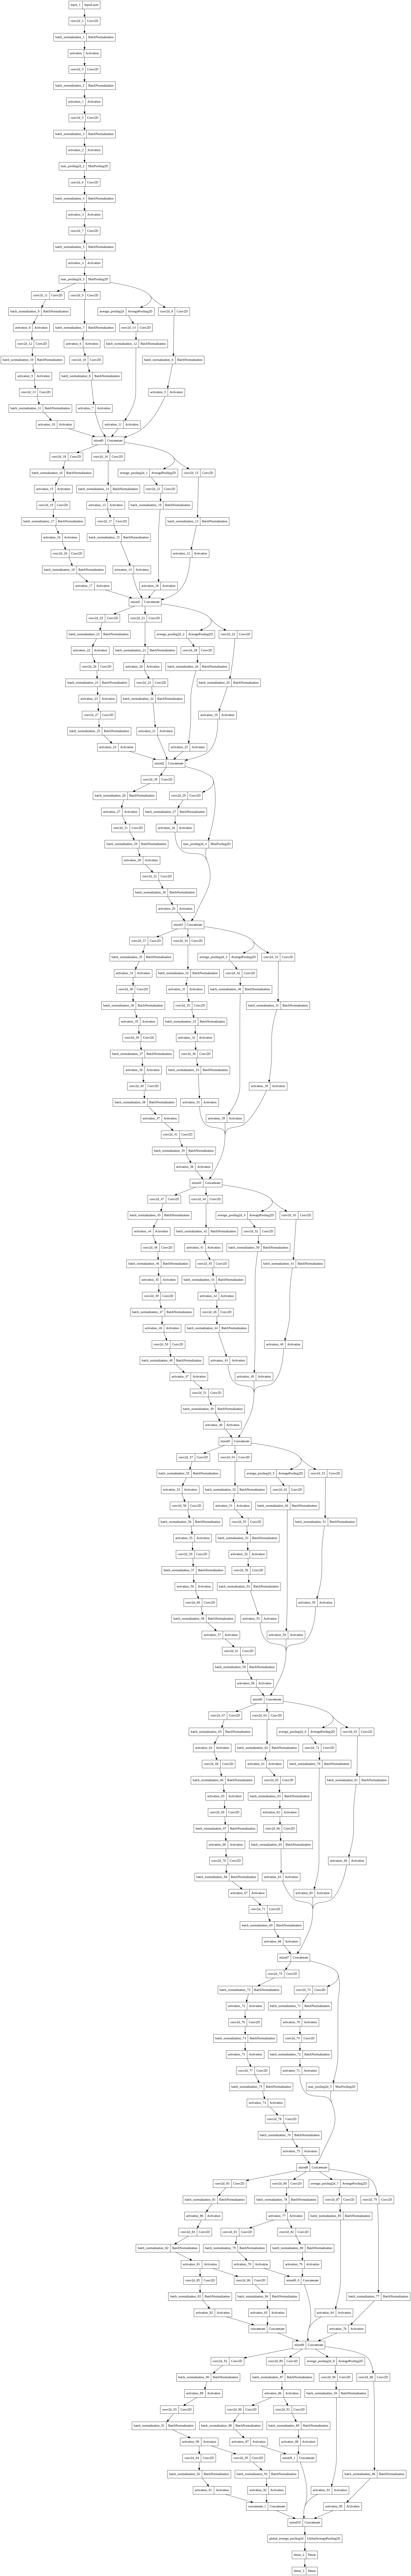

In [67]:
plot_model(model,to_file='InceptionV3model.png')

#Select an Optimizer
We will be using the Adam Optimization algorithm

In [68]:
# tf.keras optimizer
opt = tf.keras.optimizers.Adam(lr) 


#Compile The Model

In [69]:
# compile the model 
model.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [70]:
#Creating Checkpoints to save best weights
checkpoint2 = ModelCheckpoint('./checkpoints/best_weights_InceptionV3Model.hdf5', verbose=1, save_best_only=True, mode='auto')

In [71]:
# Set up some Hyperparameters

batch_size = 32
lr = 0.001


In [72]:
training_data_size = len(normal_train) + len(viral_train)+len(COVID_train)

train_steps = int(training_data_size/batch_size) #training data / batch size = 3228/32
print(train_steps)
val_steps = 50
epochs = 5

100


# Train Data

## Fit the model

we pass in:
- The training set
- the steps for how many times we want to sample a batch to be one epoch
- number of epochs
- validation set
- number of steps for validation

In [73]:
train_steps

100

In [74]:
# # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[checkpoint2])

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.7584
Epoch 1: val_loss improved from inf to 0.91719, saving model to ./checkpoints/best_weights_InceptionV3Model.hdf5
100/100 [==============================] - 55s 463ms/step - loss: 0.6543 - accuracy: 0.7584 - val_loss: 0.9172 - val_accuracy: 0.6569
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.2919 - accuracy: 0.8844
Epoch 2: val_loss improved from 0.91719 to 0.35303, saving model to ./checkpoints/best_weights_InceptionV3Model.hdf5
100/100 [==============================] - 45s 447ms/step - loss: 0.2919 - accuracy: 0.8844 - val_loss: 0.3530 - val_accuracy: 0.8581
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.9134
Epoch 3: val_loss improved from 0.35303 to 0.18712, saving model to ./checkpoints/best_weights_InceptionV3Model.hdf5
100/100 [==============================] - 45s 447ms/step - loss: 0.2241 - accuracy: 0.9134 - val_lo

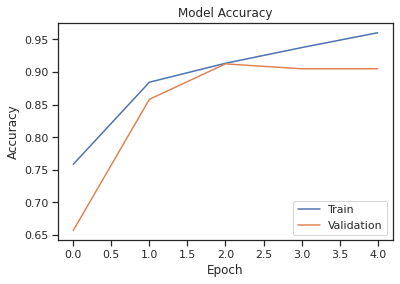

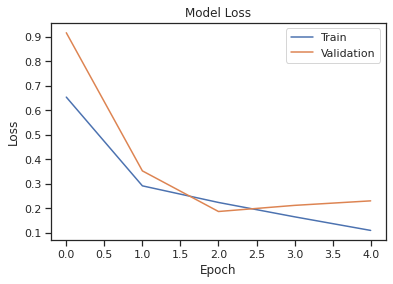

In [75]:
plot_loss_acc(history)

We are going to train the model for more epochs, with more callbacks added to optimise the training process.

In [76]:
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor = 0.9, patience=2,cooldown=1, min_lr = 0.00001) 
lr_print = tf.keras.callbacks.LambdaCallback(on_epoch_begin=lambda epoch,logs: print("lr:",K.eval(model.optimizer.lr)))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)


In [77]:
# # Train the model with validation 
history2 = model.fit ( train_dataset, steps_per_epoch = train_steps,
                   epochs = 10,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[checkpoint2,lr_print,reduce_LR,early_stopping])

lr: 0.001
Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9622
Epoch 1: val_loss improved from 0.18712 to 0.14746, saving model to ./checkpoints/best_weights_InceptionV3Model.hdf5
100/100 [==============================] - 45s 447ms/step - loss: 0.0978 - accuracy: 0.9622 - val_loss: 0.1475 - val_accuracy: 0.9475 - lr: 0.0010
lr: 0.001
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.9725
Epoch 2: val_loss did not improve from 0.14746
100/100 [==============================] - 44s 438ms/step - loss: 0.0743 - accuracy: 0.9725 - val_loss: 0.1679 - val_accuracy: 0.9400 - lr: 0.0010
lr: 0.001
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9747
Epoch 3: val_loss did not improve from 0.14746
100/100 [==============================] - 44s 439ms/step - loss: 0.0676 - accuracy: 0.9747 - val_loss: 0.2078 - val_accuracy: 0.9300 - lr: 0.0010
lr: 0.00090000004
Epoch 4/10
1

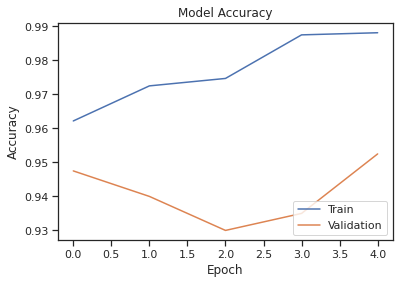

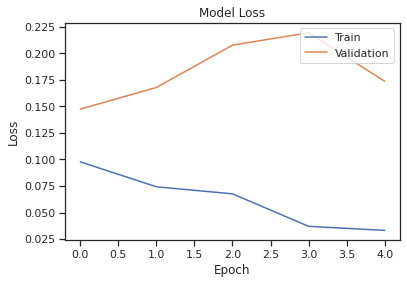

In [78]:
plot_loss_acc(history2)

#Data-Driven Insights
##1. Evaluation of model on test data using best weights

In [79]:
model.load_weights('./checkpoints/best_weights_InceptionV3Model.hdf5')


In [80]:
metrics = model.evaluate(test_dataset,steps=50)
print("Test accuracy:",metrics[1])

50/50 [==============================] - 9s 178ms/step - loss: 0.1605 - accuracy: 0.9350
Test accuracy: 0.9350000023841858


In [81]:
#preparation for confusion matrix

preds = model.predict(test_dataset,steps=10)
preds = preds.argmax(axis=-1)
print(preds.shape)
test_labels = test_labels_list[0:320]
print(len(test_labels))

(320,)
320


##2.Plotting Confusion Matrix

In [82]:
from sklearn.metrics import confusion_matrix
import itertools
 
cm = confusion_matrix(test_labels,preds)

In [83]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Normalized confusion matrix
[[0.91262136 0.01941748 0.06796117]
 [0.00925926 0.99074074 0.        ]
 [0.08256881 0.01834862 0.89908257]]


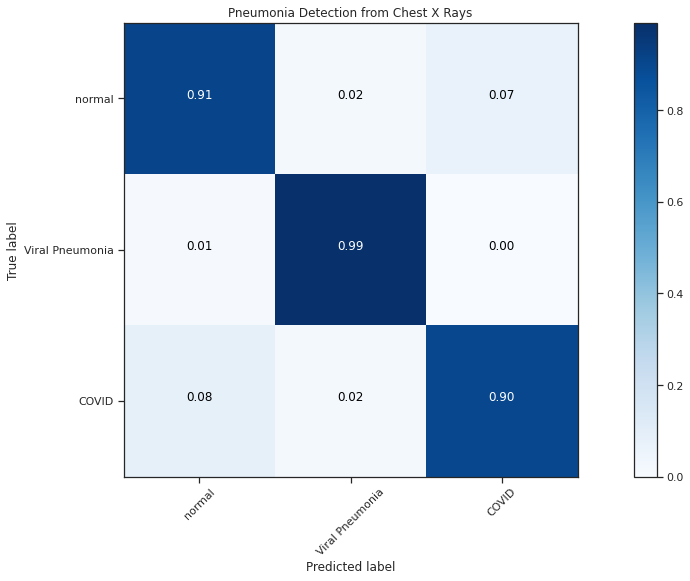

In [84]:
cm_plot_labels = ['normal','Viral Pneumonia','COVID']
import numpy as np


# # Plot normalized confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                      title='Pneumonia Detection from Chest X Rays')

plt.show()

#Saving Model (With Transfer Learning) and its best weights

In [85]:
model.save('pneumoniadetection.h5')

In [86]:
model.save_weights('pneumonia_weights_v1.h5', save_format='h5')

##Testing Model on Chest-XRay Images

In [87]:
!ls ./COVID-19_Radiography_Dataset

 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		     'Viral Pneumonia'
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 Normal


Visualise a COVID Chest X-Ray Image

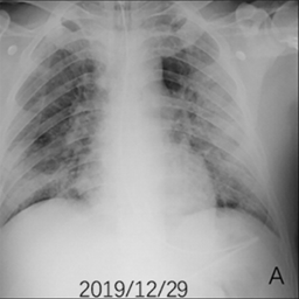

In [88]:
from IPython.display import Image

Image('./COVID-19_Radiography_Dataset/COVID/images/COVID-1011.png',width=800)

In [89]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

img_path = './COVID-19_Radiography_Dataset/COVID/images/COVID-1011.png'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

pred = model.predict(x)
print('Predicted:', pred)

print(np.argmax(pred))

result= np.argmax(pred)
if result==0:
    print("Normal")
elif result==1:
    print("Viral Pneumonia Detected ")
elif result == 2:
  print("COVID-induced Pneumonia Detected")

Input image shape: (1, 299, 299, 3)
Predicted: [[1.0828864e-04 4.8641136e-06 9.9988687e-01]]
2
COVID-induced Pneumonia Detected


Visualising a NORMAL Chest XRay Image

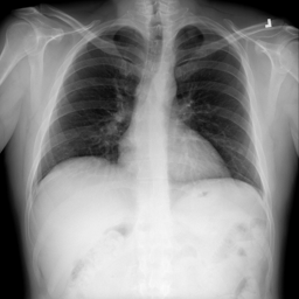

In [90]:
from IPython.display import Image

Image('./COVID-19_Radiography_Dataset/Normal/images/Normal-10004.png',width=800)

In [91]:
img_path = './COVID-19_Radiography_Dataset/Normal/images/Normal-10004.png'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

pred = model.predict(x)
print('Predicted:', pred)

print(np.argmax(pred))

result= np.argmax(pred)
if result==0:
    print("Normal")
elif result==1:
    print("Viral Pneumonia Detected ")
elif result == 2:
  print("COVID-induced Pneumonia Detected")

Input image shape: (1, 299, 299, 3)
Predicted: [[9.9684083e-01 4.0325413e-06 3.1550999e-03]]
0
Normal


Visualising a Viral Pneumonia Chest XRay Image

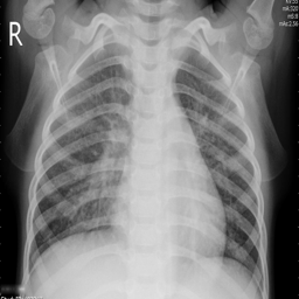

In [92]:
from IPython.display import Image

Image('./COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-101.png',width=800)

In [93]:
img_path = './COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-101.png'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

pred = model.predict(x)
print('Predicted:', pred)

print(np.argmax(pred))

result= np.argmax(pred)
if result==0:
    print("Normal")
elif result==1:
    print("Viral Pneumonia Detected ")
elif result == 2:
  print("COVID-induced Pneumonia Detected")

Input image shape: (1, 299, 299, 3)
Predicted: [[2.1454840e-04 9.9978119e-01 4.3012046e-06]]
1
Viral Pneumonia Detected 
